# Actor-critic methods

## Principe d'actor-critic

L'idée est d'avoir deux fonctions:

- L'une, que l'on va appeler l'actor, qui va décider des actions à prendre: il s'agit de la fameuse fonction ${\pi(s)}$ du RL, qui à chaque état ${s}$ associe une distribution de probabilité sur les actions, une action étant plus probable pour cet état si il est plus pertinent de l'effectuer. 
- L'autre, la critique, va dire à l'actor si ça décision a été bonne ou non et comment l'améliorer. En clair, le critic permet de mettre à jour l'actor. Il s'agit par exemple des fonctions ${V(s)}$ (value function) qui à chaque état associe une valeur d'espérance de récompense, ou ${Q(s, a)}$ qui a chaque couple (état, action) associe une valeur d'espérance de récompense.

Il existe plusieurs algorithmes Actor-critic en RL, qui difèrent les uns des autres souvent par la fonction utilisée pour jouer le rôle de critic.

- ${Q(s,a)}$, qui va donner le Q Actor-critic
- ${G_t}$, qui est une somme discounted des récompenses futures à partir de ${t}$, et qui va donner REINFORCE
- ${A(s,a)}$ la fonction avantage, qui va donner Advantage actor-critic, que nous allons justement voir.

## A2C (Advantage Actor-Critic)

**A2C** (pour advantage actor critic) introduit une fonction avantage notée ${A(s,a)}$ qui est: _combien est-il avantageux, quand je suis dans l'état ${s}$, de choisir l'action ${a}$?_. 

On part en fait du principe que ${Q(s,a) = V(s) + A(s,a)}$. Puisque ${V(s)}$ est une estimation de la récompense moyenne à long terme à partir de ${s}$, y ajouter ${A(s,a)}$ (qui peut être une valeur négative) qui représente la différence par rapport à la récompense moyenne qu'a le fait de choisir l'action ${a}$ permet de retrouver ${Q(s,a)}$ la fonction qui a un couple ${(s,a)}$ associe la récompense moyenne à long terme.

On a donc aussi: ${A(s,a) = Q(s,a) - V(s)}$

L'avantage d'avoir une fonction advantage à apprendre plutôt qu'une fonction Q, est qu'elle permet de réduire la variance du modèle, en introduisant de plus petites valeurs.

In [1]:
import torch
import torch.nn as nn

class ActorCritic(nn.Module):
    def __init__(self, input_dim, num_actions, hidden_size):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions

        self.critic = nn.Sequential(nn.Linear(input_dim, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, 1))

        self.actor = nn.Sequential(nn.Linear(input_dim, hidden_size), nn.Tanh(), 
            nn.Linear(hidden_size, num_actions))

    def forward(self, observation):
        value = self.critic(observation)
        d = 1
        if len(observation.size()) == 1:
            d = 0
        policy_s = nn.functional.softmax(self.actor(observation), dim=d)

        return value, policy_s

## Commençons par un petit jeu simple, cartpole

Ce jeu est disponible dans l'environnement gym. Le principe est simple: faire tenir en équilibre un baton posé à la verticale sur un chariot. Pour ça, il faut bouger le chariot soit à droite, soit à gauche. Le jeu se termine quand le baton est tombé (on considère qu'au bout d'une inclinaison à 30 degrés, il est tombé).

Ce jeu est modélisé par des états codés comme un vecteur en 4 dimensions modélisant 4 mesures physiques (position du chariot, angles...) et deux actions possible: bouger d'un cran vers la droite, bouger d'un cran vers la gauche.

<img src="images/cartpole.png" width="500">

Configurons l'environnement cartpole avec gym:

In [6]:
import gym

env = gym.make('CartPole-v1')
outdir = 'TP4/cartpole-v0/DQN-agent-results'
envm = gym.wrappers.Monitor(env, directory=outdir, force=True, video_callable=False)
env.seed(0)
env.verbose = False

print("un état: ", envm.reset())
print("nombre d'actions possibles ", env.action_space.n)

un état:  [-0.04456399  0.04653909  0.01326909 -0.02099827]
nombre d'actions possibles  2


In [7]:
import numpy as np
import time

NUM_EPISODES = 1000
NUM_STEPS = 500
GAMMA = 0.99

learning_rate = 0.001

hidden_layer_size = 64

input_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

actor_critic = ActorCritic(input_dim, action_dim, hidden_layer_size)
optimizer = torch.optim.Adam(actor_critic.parameters(), lr=learning_rate)

roi_arouf = []
nurmagomedov = []

## APPRENTISSAGE SUR DES SCENARIOS FINIS:
## JOUER UN SCENARIO COMPLET, PUIS APPRENDRE DESSUS

start = time.time()
# jouer un NUM_EPISODES "parties"
for episode in range(NUM_EPISODES):
    logprobs = []
    values = []
    rewards = []
    
    state = env.reset()
    # jouer au max NUM_STEPS "coups" pour cette partie
    # ... avec la politique actuelle bien sûr
    start_episode = time.time()
    for steps in range(NUM_STEPS):
        value, policy = actor_critic.forward(torch.from_numpy(state).float())
        value = value.detach().numpy()[0]
        policy_detach = policy.detach().numpy() 
        
        # on sample une action d'apres la distribution de la politique courante pour cet état
        chosen_action = np.random.choice(action_dim, p=policy_detach)
        # calculer la log-prob de la politique pour l'action choisie
        # pour pouvoir calculer le gradient par la suite
        log_prob = torch.log(policy.squeeze(0)[chosen_action])
        
        # effectuer l'action et récupérer le reward
        new_state, reward, done, _ = env.step(chosen_action)
        
        rewards.append(reward)
        values.append(value)
        logprobs.append(log_prob)
        state = new_state
        
        if done or steps == NUM_STEPS-1:
            # Si on est à la fin de l'épisode...
            Qval, _ = actor_critic.forward(torch.from_numpy(new_state).float())
            Qval = Qval.detach().numpy()[0]
            
            roi_arouf.append(np.sum(rewards))
            nurmagomedov.append(steps)
            break

    # compute Q values
    Qvals = np.zeros_like(values)
    for t in reversed(range(len(rewards))):
        Qval = rewards[t] + GAMMA * Qval  #etape 2 update Qval 
        Qvals[t] = Qval
        
    values = torch.FloatTensor(values)
    Qvals = torch.FloatTensor(Qvals)
    logprobs = torch.stack(logprobs)
        
    advantage = Qvals - values #calcul de A (étape 3)
    
    ## Apprentissage
    
    # compute policy loss 
    actor_loss = (-logprobs * advantage).mean()
    # compute value loss (mse loss)
    critic_loss = advantage.pow(2).mean()
        
    ac_loss = actor_loss + critic_loss

    optimizer.zero_grad()
    ac_loss.backward()
    optimizer.step()
    
    if episode % 100 == 0:
        print("episode {}".format(episode)+" done in {0:.2f}s".format(time.time() - start_episode)+
             " reward: ", np.sum(rewards))
    
print("done in %f seconds" % (time.time() - start))

episode 0 done in 0.02s reward:  12.0
episode 100 done in 0.01s reward:  16.0
episode 200 done in 0.06s reward:  65.0
episode 300 done in 0.08s reward:  114.0
episode 400 done in 0.10s reward:  91.0
episode 500 done in 0.11s reward:  81.0
episode 600 done in 0.15s reward:  119.0
episode 700 done in 0.09s reward:  125.0
episode 800 done in 0.09s reward:  127.0
episode 900 done in 0.29s reward:  288.0
done in 112.522234


In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

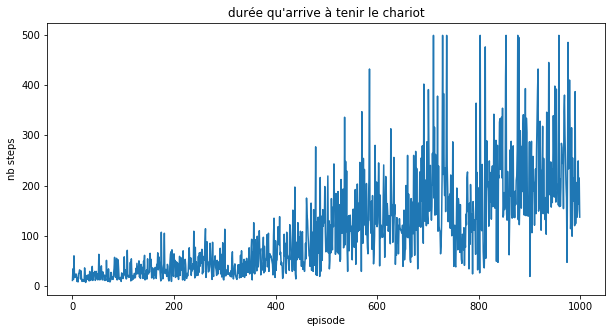

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(nurmagomedov)
plt.title("durée qu'arrive à tenir le chariot")
plt.xlabel("episode")
plt.ylabel("nb steps")
plt.show()

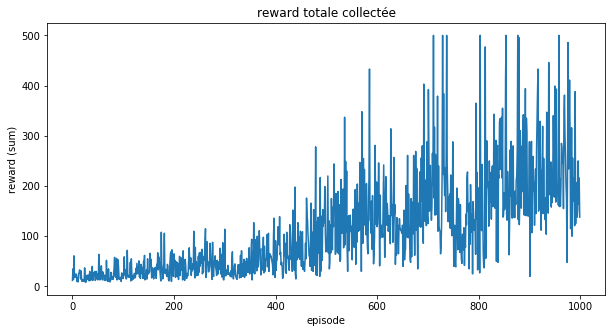

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(roi_arouf)
plt.title("reward totale collectée")
plt.xlabel("episode")
plt.ylabel("reward (sum)")
plt.show()